<a id="1"></a>
<h1 style='background:deeppink; border:0; color:white'><center>1.Data loading and overview</center></h1>

In [6]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# from matplotlib_venn import venn2
from matplotlib import pyplot
import seaborn as sns
from tqdm import tqdm
from scipy.signal import find_peaks
from tslearn.clustering import TimeSeriesKMeans
from sklearn.metrics import mean_absolute_error
from sklearn.metrics.pairwise import cosine_similarity

In [7]:
DATA_DIR = Path("/home/knikaido/work/Ventilator-Pressure-Prediction/data/ventilator-pressure-prediction")
OUTPUT_DIR = Path('./output/')

In [8]:
colors = [plt.cm.tab10(i) for i in range(20)]

In [9]:
train = pd.read_csv(DATA_DIR / 'train.csv',index_col=0)
test  = pd.read_csv(DATA_DIR / 'test.csv', index_col=0)

/usr/local/lib/python3.8/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [10]:
oof = pd.read_csv('../75/output/oof_total_75.csv',index_col=0)
sub = pd.read_csv('../75/output/submission_median_75.csv',index_col=0)

In [11]:
train = pd.merge(train, oof, left_index=True, right_index=True, how='left', suffixes=('', '_oof'))
test = pd.merge(test, sub, left_index=True, right_index=True, how='left', suffixes=('', '_sub'))

In [12]:
train['pressure_oof'] = train['pred'].isna()*1
test['pressure_sub'] = test['pressure'].isna()*1

In [13]:
train['RC'] = train['R'].astype(str) + '_' + train['C'].astype(str)
test['RC'] = test['R'].astype(str) + '_' + test['C'].astype(str)

In [26]:
train['num'] = train.groupby(['breath_id', 'RC']).cumcount()
u_in_table = pd.pivot_table(train, index=['breath_id', 'RC'], columns='num', values='pressure')
u_in_table = u_in_table.reset_index()
u_in_table

num    breath_id     RC         0          1          2          3          4  \
0              1  20_50  5.837492   5.907794   7.876254  11.742872  12.234987   
1              2  20_20  6.048398   7.524743   9.282297  10.336829   9.844714   
2              3  50_20  5.064168   5.064168   6.751420  12.305289  18.702784   
3              4  50_50  6.259305   5.767190   6.540513   8.649578  10.758642   
4              5   5_50  6.329607   7.384139   8.368369   9.001088   9.774412   
...          ...    ...       ...        ...        ...        ...        ...   
75445     125740  50_50  6.470211   5.837492   6.259305   6.610815   7.102930   
75446     125742  20_10  6.329607  11.391361  20.952453  34.661371  27.420250   
75447     125743  20_10  6.259305   5.907794   6.048398   5.978096   6.048398   
75448     125745  50_50  6.962326   8.790182  12.445893  21.303964  22.991215   
75449     125749  50_10  3.939334   5.345377   9.563505  15.117375  15.468886   

num            5          6          7  ...        70        71        72  \
0      12.867706  14.695562  15.890699  ...  6.751420  6.540513  6.399909   
1      11.180455  11.531965  11.110153  ...  5.626585  5.134470  5.485981   
2      24.537862  27.842063  27.209344  ...  6.470211  6.540513  6.681117   
3      13.359821  16.031303  19.054295  ...  7.032628  6.259305  6.892024   
4      10.125923  10.828944  11.250757  ...  5.556283  5.626585  5.696887   
...          ...        ...        ...  ...       ...       ...       ...   
75445   7.595045   8.368369   9.071390  ...  6.610815  6.259305  6.470211   
75446  20.038525  30.794753  30.583847  ...  6.259305  6.399909  6.118700   
75447   6.681117   8.087160   8.508973  ...  6.399909  6.118700  6.259305   
75448  22.077287  22.780309  24.397258  ...  6.751420  6.821722  7.384139   
75449  17.015533  18.702784  18.351274  ...  4.009636  4.009636  4.009636   

num          73        74        75        76        77        78        79  
0      6.751420  6.470211  6.399909  6.610815  6.329607  6.540513  6.470211  
1      5.064168  5.204772  5.064168  5.204772  4.993866  5.064168  5.134470  
2      6.540513  6.329607  6.610815  6.681117  6.048398  6.470211  6.610815  
3      6.892024  6.189002  7.032628  6.540513  6.399909  6.962326  6.329607  
4      5.767190  5.767190  5.837492  5.837492  5.837492  6.048398  6.048398  
...         ...       ...       ...       ...       ...       ...       ...  
75445  6.470211  6.259305  6.681117  6.540513  6.189002  6.470211  6.399909  
75446  6.399909  6.329607  6.048398  6.329607  6.259305  6.259305  6.540513  
75447  6.470211  6.189002  6.329607  6.540513  6.189002  6.329607  6.329607  
75448  6.962326  6.751420  7.313837  7.102930  6.540513  7.032628  7.173232  
75449  4.009636  3.939334  3.869032  3.869032  3.798729  4.079938  3.869032  

[75450 rows x 82 columns]

In [31]:
test['num'] = test.groupby(['breath_id', 'RC']).cumcount()
u_in_table_test = pd.pivot_table(test, index=['breath_id', 'RC'], columns='num', values='pressure')
u_in_table_test = u_in_table_test.reset_index()
u_in_table_test

num    breath_id     RC         0          1          2          3          4  \
0              0   5_20  6.206704   5.991534   7.201249   7.794795   9.245929   
1              8   5_50  6.064586   7.086612   6.609179   7.775061   6.956622   
2             11  50_10  6.496150   9.717120  14.502734  21.203750  23.374680   
3             24  50_10  3.521326   3.531926   4.177189   5.428145   7.012122   
4             31  20_50  6.331299  12.639994  18.418348  18.255120  13.906647   
...          ...    ...       ...        ...        ...        ...        ...   
50295     125741   5_10  6.126682   7.753950  13.314858  17.385864  20.339886   
50296     125744  50_20  6.504771   5.961561   6.289273   6.337383   6.373074   
50297     125746  50_20  5.677257   6.763713  13.587172  32.244698  33.503872   
50298     125747  50_10  6.533090   9.002924  12.612516  17.446535  18.197435   
50299     125748  20_10  3.994529   5.512895  11.227881  10.207408   8.243916   

num            5          6          7  ...         70         71         72  \
0      10.413258  11.689682  12.782974  ...  12.488290  12.649663  12.860978   
1       8.335255   7.205261   8.766736  ...   8.994814   9.064335   9.134336   
2      22.131035  16.963404  14.118087  ...  24.525059  22.075062  23.680023   
3       8.632556  10.469698  11.943836  ...  34.694622  34.059578  33.192394   
4      17.056326  19.266325  14.440380  ...  20.579695  22.478502  22.465740   
...          ...        ...        ...  ...        ...        ...        ...   
50295  23.057987  25.387768  27.543116  ...  30.177530  29.897430  30.228832   
50296   6.383664   6.387239   6.537352  ...  15.347270  15.952755  16.445852   
50297  21.215910  16.020452  24.702559  ...  30.050499  30.271648  30.357010   
50298  16.042355  13.395704  12.155218  ...  23.588936  21.073664  21.354760   
50299   9.844461  10.274080   9.472291  ...  15.666624  15.814776  15.784472   

num           73         74         75         76         77         78  \
0      13.135695  13.411919  13.842681  14.278128  14.635754  14.746702   
1       9.178423   9.225471   9.305505   9.377071   9.577138  10.035856   
2      25.263771  24.918867  24.956316  25.343473  26.205677  26.327639   
3      28.902480  34.224090  35.102142  29.458681  22.013530  12.374147   
4      22.515139  22.512486  22.539532  22.530659  22.492016  21.689606   
...          ...        ...        ...        ...        ...        ...   
50295  28.800873  30.780695  30.925714  30.790134  30.463062  24.824902   
50296  16.767982  16.674986  16.943197  17.057340  16.506704  16.842686   
50297  30.449242  30.429214  30.451372  30.300247  28.618713  26.394249   
50298  25.727064  24.341932  25.587868  26.004015  25.863365  25.986595   
50299  16.331850  16.719526  16.857979  17.300259  17.354898  18.585789   

num           79  
0      15.523957  
1      11.244264  
2      27.453112  
3      11.757297  
4      22.119595  
...          ...  
50295  25.971619  
50296  17.369541  
50297  23.634958  
50298  26.766731  
50299  18.560710  

[50300 rows x 82 columns]

In [32]:
max_mins = []
for i in range(80):
    max_mins.append([np.max(u_in_table.loc[:, i]), np.min(u_in_table.loc[:, i])])
max_mins = np.array(max_mins)

max_mins_test = []
for i in range(80):
    max_mins_test.append([np.max(u_in_table_test.loc[:, i]), np.min(u_in_table_test.loc[:, i])])
max_mins_test = np.array(max_mins_test)

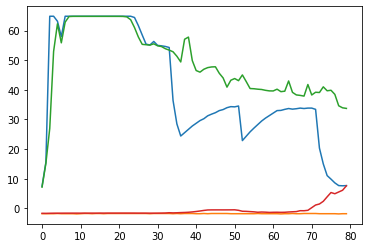

In [33]:
plt.plot(max_mins[:, 0])
plt.plot(max_mins[:, 1])
plt.plot(max_mins_test[:, 0])
plt.plot(max_mins_test[:, 1])

In [34]:
max_mins_test[:, 1]

array([-1.692034  , -1.7104559 , -1.6785855 , -1.6517807 , -1.665169  ,
       -1.6453549 , -1.6364918 , -1.637841  , -1.6323029 , -1.6298491 ,
       -1.6407665 , -1.6306287 , -1.6454034 , -1.6266364 , -1.6454304 ,
       -1.6257067 , -1.6247518 , -1.6214617 , -1.6214342 , -1.6215155 ,
       -1.6205523 , -1.6167608 , -1.6195871 , -1.6213349 , -1.6240501 ,
       -1.6379471 , -1.63186   , -1.6357687 , -1.6420659 , -1.6469182 ,
       -1.636361  , -1.6186315 , -1.5878992 , -1.4949951 , -1.5471601 ,
       -1.5080105 , -1.451659  , -1.4065063 , -1.3395435 , -1.2251842 ,
       -1.0812783 , -0.9093217 , -0.71532655, -0.5639819 , -0.53753054,
       -0.53632027, -0.533849  , -0.5372492 , -0.53483486, -0.5246779 ,
       -0.50795406, -0.6808849 , -0.9949528 , -1.0323231 , -1.1170658 ,
       -1.1928284 , -1.3360671 , -1.2577444 , -1.3052362 , -1.3862875 ,
       -1.3467782 , -1.3322225 , -1.364377  , -1.341516  , -1.2439184 ,
       -1.1742753 , -1.1125665 , -0.808635  , -0.8207531 , -0.67

In [9]:
train['num'] = train.groupby(['breath_id', 'RC']).cumcount()
u_in_table = pd.pivot_table(train, index=['breath_id', 'RC'], columns='num', values='u_in')
u_in_table = u_in_table.reset_index()
u_in_table

num    breath_id     RC          0           1          2          3  \
0              1  20_50   0.083334   18.383041  22.509278  22.808822   
1              2  20_20  12.184338   13.980205  12.574163  11.730537   
2              3  50_20   0.000000    7.187242  13.338781  17.111335   
3              4  50_50   0.000000    1.262539   4.001352   6.379411   
4              5   5_50  21.424375   28.504653  29.353025  30.502095   
...          ...    ...        ...         ...        ...        ...   
75445     125740  50_50   0.000000    0.000000   0.673913   1.700763   
75446     125742  20_10  85.630231  100.000000  81.566813   0.000000   
75447     125743  20_10   0.000000    0.000000   0.000000   0.950177   
75448     125745  50_50  15.564236   23.588836  20.298696  12.326433   
75449     125749  50_10   6.030572   25.504196  21.614707  16.266744   

num            4          5          6          7  ...        70        71  \
0      25.355850  27.259866  27.127486  26.807732  ...  4.940237  4.949604   
1      12.124229  11.055636  10.774428  11.111878  ...  4.946820  4.955128   
2      18.353980  17.417672  15.353111  13.641899  ...  4.876171  4.894445   
3       8.295194   9.790410  10.874443  13.336506  ...  4.879581  4.897809   
4      31.024647  32.224651  32.364788  32.858346  ...  4.954280  4.961622   
...          ...        ...        ...        ...  ...       ...       ...   
75445   2.619867   3.397223   4.030364   4.540090  ...  4.951377  4.958965   
75446  23.328401  89.819686   0.000000   0.000000  ...  4.937050  4.946832   
75447   3.256712   4.678061   4.628657   4.970097  ...  4.935777  4.945808   
75448  10.807906  11.630441  10.997722   9.542468  ...  4.877733  4.895692   
75449  16.101221  14.700098  13.117684  13.573873  ...  1.367263  1.362261   

num          72        73        74        75        76        77        78  \
0      4.957466  4.964136  4.969730  4.974474  4.978481  4.981847  4.984683   
1      4.962164  4.968085  4.973087  4.977307  4.980860  4.983857  4.986382   
2      4.910021  4.923308  4.934620  4.944269  4.952485  4.959494  4.965451   
3      4.912832  4.925605  4.936515  4.946119  4.954007  4.960767  4.966532   
4      4.967670  4.972735  4.977117  4.980725  4.983751  4.986374  4.988504   
...         ...       ...       ...       ...       ...       ...       ...   
75445  4.965437  4.970984  4.975529  4.979396  4.982703  4.985436  4.987730   
75446  4.955088  4.962065  4.967939  4.972923  4.977126  4.980671  4.983671   
75447  4.954189  4.961282  4.967358  4.972427  4.976734  4.980354  4.983397   
75448  4.911043  4.924128  4.935280  4.944776  4.952874  4.959785  4.965696   
75449  1.357586  1.353205  1.420711  1.489714  1.488497  1.558978  1.272663   

num          79  
0      4.987079  
1      4.988518  
2      4.970562  
3      4.971585  
4      4.990306  
...         ...  
75445  4.989706  
75446  4.986201  
75447  4.985969  
75448  4.970727  
75449  1.482739  

[75450 rows x 82 columns]

In [18]:
test['num'] = test.groupby(['breath_id', 'RC']).cumcount()
u_in_table_test = pd.pivot_table(test, index=['breath_id', 'RC'], columns='num', values='u_in')
u_in_table_test = u_in_table_test.reset_index()
u_in_table_test

num    breath_id     RC           0          1          2          3  \
0              0   5_20    0.000000   7.515046  14.651675  21.230610   
1              8   5_50   16.140384  11.429617  13.755544   9.306066   
2             11  50_10   33.717608  26.595397  20.281570  13.548649   
3             24  50_10    1.203812   3.150063   4.900224   6.484965   
4             31  20_50  100.000000  58.192753  12.083520  13.780551   
...          ...    ...         ...        ...        ...        ...   
50295     125741   5_10   27.582424  93.453807  75.872361  62.859007   
50296     125744  50_20    0.000000   0.000000   0.000000   0.000000   
50297     125746  50_20    6.905471  75.198310  50.982377   0.000000   
50298     125747  50_10   21.957377  17.311344  13.192400   8.764069   
50299     125748  20_10    9.985853  35.151391   0.000000   0.000000   

num            4          5          6          7  ...        70        71  \
0      26.320956  30.486938  33.545950  35.717600  ...  4.888022  4.904545   
1      12.743169   7.150991  11.984329   5.535034  ...  4.948257  4.956422   
2       6.483971   1.112624   1.551207   2.146880  ...  4.948290  4.956376   
3       7.846378   9.015769  10.016142  10.843369  ...  1.057241  1.013402   
4      48.687221  23.392914   5.957594  44.794983  ...  4.947822  4.955945   
...          ...        ...        ...        ...  ...       ...       ...   
50295  53.223056  43.417810  34.486763  25.409192  ...  4.936668  4.946587   
50296   0.000000   0.181649   0.614875   0.991240  ...  4.896415  4.911693   
50297   0.000000  16.101901  39.468039   5.001638  ...  4.876761  4.894955   
50298   4.151136   0.826441   1.180669   1.614174  ...  4.953054  4.960400   
50299  14.323999   1.385073   0.000000   4.189347  ...  4.932934  4.943394   

num          72        73        74        75        76        77        78  \
0      4.918612  4.930615  4.940853  4.949582  4.957020  4.963363  4.968767   
1      4.963265  4.969007  4.973857  4.977955  4.981403  4.984308  4.986774   
2      4.963262  4.969188  4.974050  4.978145  4.981646  4.984537  4.986980   
3      0.975350  0.945148  0.917127  0.908260  0.900154  0.901404  0.902604   
4      4.962858  4.968655  4.973575  4.977700  4.981205  4.984142  4.986621   
...         ...       ...       ...       ...       ...       ...       ...   
50295  4.954845  4.961935  4.967854  4.972827  4.977044  4.980604  4.983633   
50296  4.924702  4.935783  4.945502  4.953518  4.960387  4.966222  4.971343   
50297  4.910459  4.923630  4.934910  4.944515  4.952710  4.959696  4.965647   
50298  4.966601  4.971997  4.976392  4.980081  4.983286  4.985904  4.988127   
50299  4.952134  4.959653  4.965959  4.971245  4.975709  4.979468  4.982648   

num          79  
0      4.973375  
1      4.988844  
2      4.989067  
3      0.912538  
4      4.988717  
...         ...  
50295  4.986171  
50296  4.975551  
50297  4.970716  
50298  4.990027  
50299  4.985373  

[50300 rows x 82 columns]

In [21]:
def search_similar_id(target_id, th):
    """
    Find a breath_id with a similar u_in pattern.

    Parameters
    ----------
    target_id : int
        Target breath_id
    th : float
        Cosine similarity threshold

    Returns
    -------
    similar_id : list
        List of ids with similar patterns
    """
    
    if target_id in u_in_table_test['breath_id'].tolist():
        target_rc = u_in_table_test[u_in_table_test['breath_id']==target_id]['RC'].values[0]
        target_vec = u_in_table_test[u_in_table_test['breath_id']==target_id].to_numpy()[:,2:]

        refer_table = u_in_table[(u_in_table['RC']==target_rc)].reset_index(drop=True)
        refer_vec = refer_table.to_numpy()[:,2:]
        breaths = refer_table['breath_id'].unique().tolist()
        breath_map = {i:b for i,b in enumerate(breaths)}

        cs = cosine_similarity(target_vec, refer_vec)[0]
        similar_idx = list(np.where(cs>th)[0])
        similar_id = [breath_map[i] for i in similar_idx]
    
    else:
        similar_id = []
        
    return similar_id

In [34]:
def viz_similar_id(target_id, th=0.999):
    """
    Visualize and compare u_in and pressure of breath_id with similar patterns.

    Parameters
    ----------
    target_id : int
        Target breath_id
    th : float
        Cosine similarity threshold
    """
    rc = u_in_table_test[u_in_table_test['breath_id']==target_id]['RC'].values[0]
    similar_ids = search_similar_id(target_id, th)
    viz_id = [target_id] + similar_ids
    
    fig, axes = plt.subplots(figsize=(16, 9), nrows=2,sharex=True)
    for i, id_ in enumerate(viz_id):
        lw = 3 if i ==  0 else 1
        if i == 0:
            tmp = test[test['breath_id']==id_].copy()
        else:
            tmp = train[train['breath_id']==id_].copy()
        axes[0].plot(tmp['time_step'], tmp['u_in'], label='breath_id : ' + str(id_), lw=lw, color='red')
        axes[1].plot(tmp['time_step'], tmp['pressure'], label='breath_id : ' + str(id_), lw=lw, color='red')
        axes[0].legend(loc='upper right')
        axes[0].grid(color='g', linestyle=':', linewidth=0.3)
        axes[0].set_title('u_in')
        axes[1].legend(loc='upper right')
        axes[1].grid(color='g', linestyle=':', linewidth=0.3)
        axes[1].set_title('pressure')
        fig.suptitle(f'target_id : {target_id}  (RC={rc})')
        
    return u_in_table[u_in_table['breath_id'].isin(viz_id)]

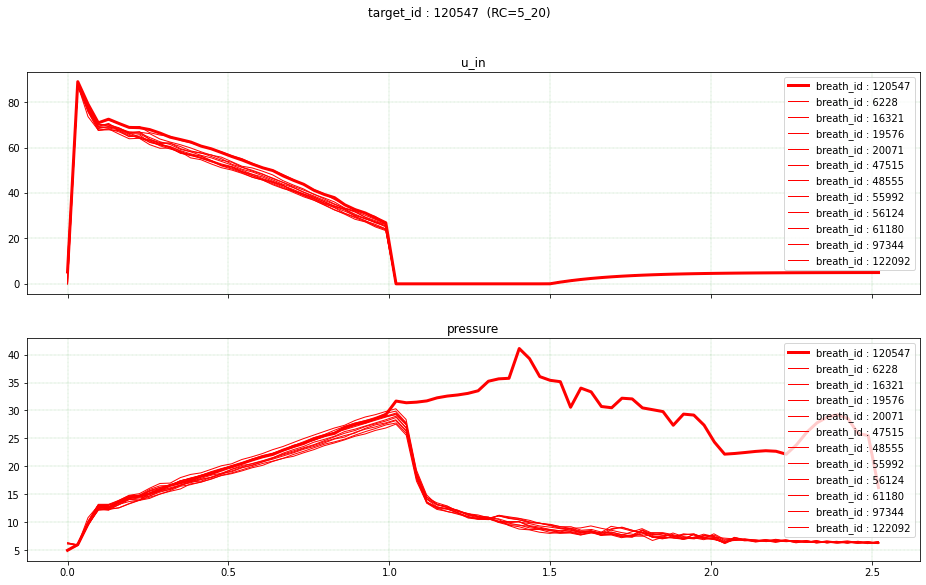

In [67]:
near_table = viz_similar_id(target_id=u_in_table_test['breath_id'][48215])
# near_table

In [18]:
near_table

num    breath_id     RC         0          1          2          3          4  \
119          167  50_10  0.000000  22.900243  31.923252  31.020356  26.833107   
2297        3766  50_10  0.000000  18.926398  26.858754  27.124400  23.519319   
7738       12839  50_10  0.000000  16.436564  27.058197  29.794142  26.710092   
11686      19462  50_10  0.592467  19.782796  28.200271  29.186768  25.827879   
14245      23680  50_10  1.125564  20.688068  27.361234  26.292612  22.646038   
14402      23945  50_10  0.000000  20.467823  29.787175  30.352996  26.127210   
15737      26134  50_10  0.000000  17.175189  26.005219  26.508625  21.982051   
22922      38054  50_10  3.592156  20.461510  29.252887  30.797054  28.056778   
29214      48622  50_10  1.600763  24.437596  32.334679  31.585793  27.651619   
38284      63711  50_10  2.298513  21.311591  29.456672  29.249699  25.061597   
39406      65572  50_10  0.781223  22.280571  30.032557  28.963649  24.521726   
65122     108481  50_10  0.686255  21.823475  30.753311  32.235779  29.563336   
69925     116555  50_10  0.000000  20.440007  31.327338  32.580594  28.204627   

num            5          6          7  ...        70        71        72  \
119    23.399703  19.802951  16.518710  ...  4.863754  4.883677  4.900674   
2297   19.300304  16.542357  14.430882  ...  4.864963  4.884758  4.901626   
7738   20.697131  15.515789  11.335882  ...  4.867744  4.887123  4.903638   
11686  20.426787  16.186376  12.975671  ...  4.861635  4.881890  4.899179   
14245  19.672251  16.654440  13.903615  ...  4.860816  4.881167  4.898546   
14402  20.764500  16.682157  13.406629  ...  4.864983  4.884741  4.901609   
15737  16.086097  12.249261   9.893796  ...  4.866427  4.885941  4.902608   
22922  23.453174  19.479362  15.999840  ...  4.870217  4.889228  4.905447   
29214  23.986952  20.175327  16.310333  ...  4.861640  4.881870  4.899137   
38284  19.391974  15.702599  12.833720  ...  4.868095  4.887390  4.903838   
39406  20.327769  16.085780  12.648680  ...  4.860039  4.880461  4.897907   
65122  24.868039  20.620978  16.738254  ...  4.861436  4.881761  4.899114   
69925  21.636586  16.308749  12.224928  ...  4.864239  4.884085  4.901039   

num          73        74        75        76        77        78        79  
119    4.915193  4.927598  4.938189  4.947225  4.954941  4.961528  4.967155  
2297   4.916017  4.928330  4.938803  4.947751  4.955401  4.961917  4.967485  
7738   4.917751  4.929796  4.940083  4.948861  4.956366  4.962761  4.968208  
11686  4.913930  4.926534  4.937289  4.946462  4.954296  4.960982  4.966692  
14245  4.913365  4.926015  4.936836  4.946068  4.953959  4.960696  4.966453  
14402  4.915982  4.928280  4.938773  4.947728  4.955363  4.961891  4.967463  
15737  4.916876  4.929034  4.939439  4.948291  4.955847  4.962295  4.967819  
22922  4.919290  4.931104  4.941218  4.949835  4.957184  4.963456  4.968809  
29214  4.913870  4.926483  4.937235  4.946427  4.954262  4.960961  4.966672  
38284  4.917888  4.929895  4.940149  4.948910  4.956371  4.962755  4.968201  
39406  4.912827  4.925581  4.936459  4.945748  4.953685  4.960467  4.966248  
65122  4.913876  4.926477  4.937241  4.946430  4.954268  4.960978  4.966683  
69925  4.915491  4.927851  4.938405  4.947401  4.955103  4.961666  4.967271  

[13 rows x 82 columns]

In [183]:
train_near = train[train['breath_id'].isin(near_table['breath_id'].unique())]

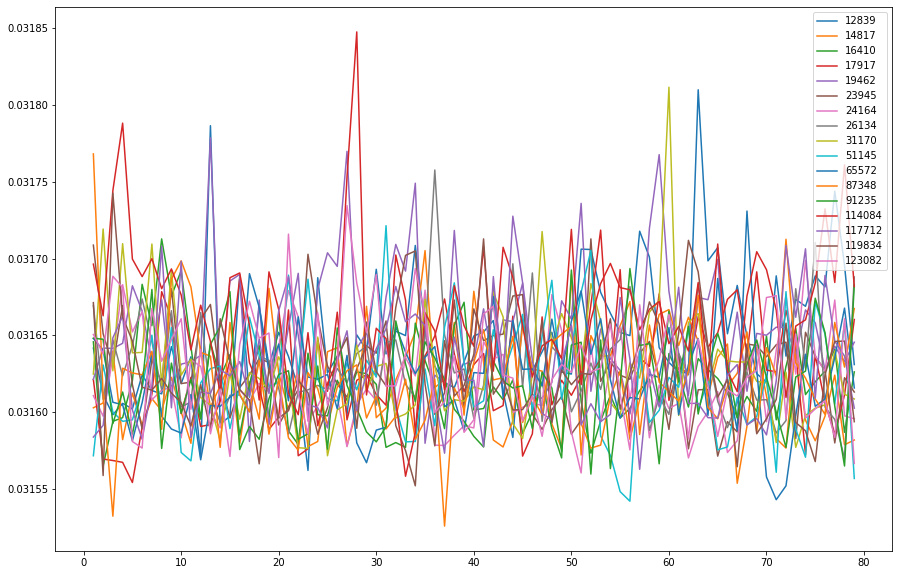

In [185]:
b_ids = train_near['breath_id'].unique()
plt.figure(figsize=(15, 10))
for i, b_id in enumerate(b_ids):
    tmp_df = train_near[train_near['breath_id']==b_id]
    plt.plot(np.arange(len(tmp_df['time_step'])), tmp_df['time_step'].diff(), label=b_id)
plt.legend()

# R=50, C=50

In [206]:
train_rc = train[(train['R']==50) & (train['C']==50)].reset_index()

In [207]:
train_rc_g_by = train_rc.groupby('breath_id')['u_in'].apply(list).apply(pd.Series)
kmeans = KMeans(n_clusters=10, random_state=777)
kmeans.fit(train_rc_g_by.values)

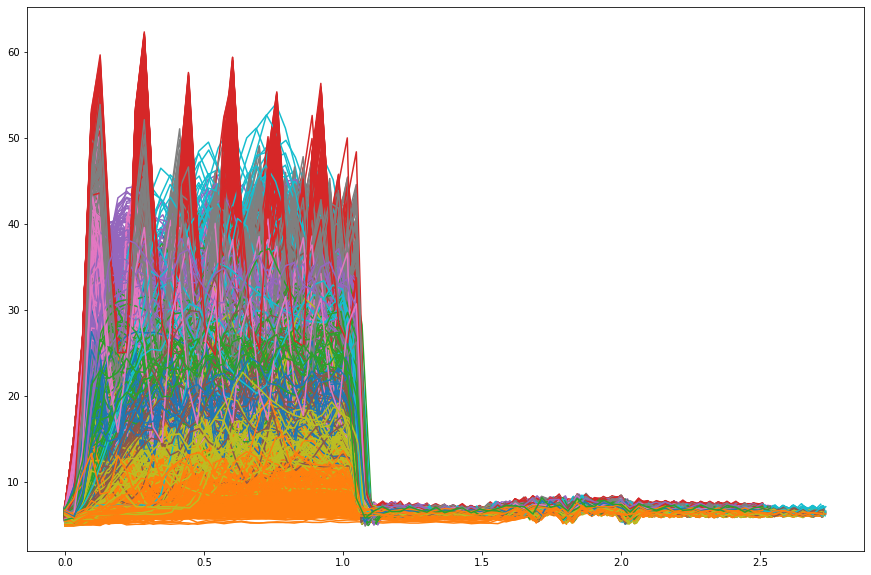

In [210]:
train_rc = train[(train['R']==50) & (train['C']==50)].reset_index()
b_ids = train_rc['breath_id'].unique()
plt.figure(figsize=(15, 10))
for i, b_id in enumerate(b_ids):
    tmp_df = train_rc[train_rc['breath_id']==b_id]
    plt.plot(tmp_df['time_step'], tmp_df['pressure'], label='pressure', color=colors[kmeans.labels_[i]])

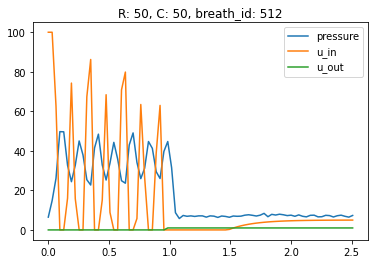

In [73]:
R = tmp_df.iloc[0, 2]
C = tmp_df.iloc[0, 3]
plt.plot(tmp_df['time_step'], tmp_df['pressure'], label='pressure')
plt.plot(tmp_df['time_step'], tmp_df['u_in'], label='u_in')
plt.plot(tmp_df['time_step'], tmp_df['u_out'], label='u_out')
plt.title(f'R: {R}, C: {C}, breath_id: {b_id}')
plt.legend()

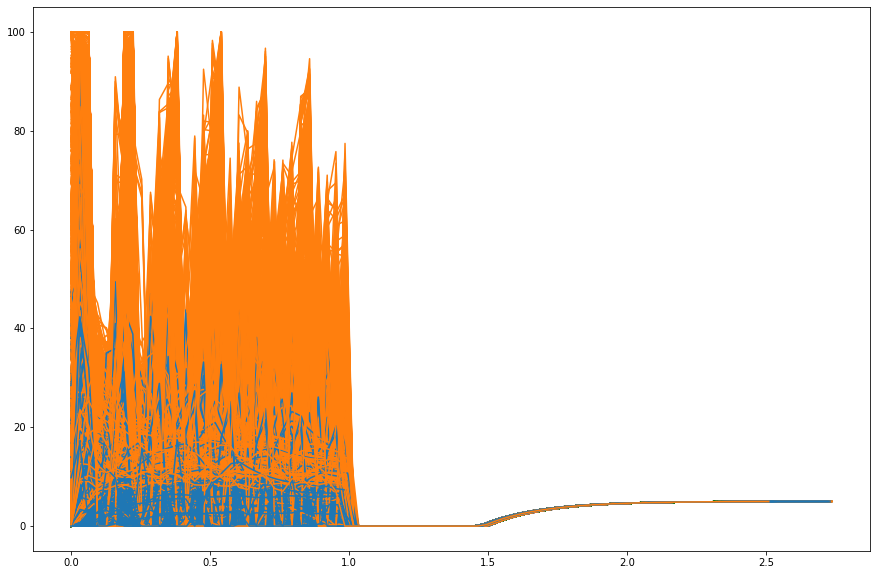

In [74]:
train_rc = train[(train['R']==50) & (train['C']==50)].reset_index()
# b_ids = train_rc[train_rc['u_in']>=100]['breath_id'].unique()
b_ids = train_rc['breath_id'].unique()

plt.figure(figsize=(15, 10))
u_out0_len = []
for i, b_id in enumerate(b_ids):
    tmp_df = train_rc[train_rc['breath_id']==b_id]
    plt.plot(tmp_df['time_step'], tmp_df['u_in'], label='u_in', color=colors[kmeans.labels_[i]])
    u_out0_len.append(tmp_df[tmp_df['u_out']==0]['time_step'].values[-1])

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


count    8189.000000
mean        0.970103
std         0.013364
min         0.931081
25%         0.960053
50%         0.965086
75%         0.984118
max         0.999466
dtype: float64

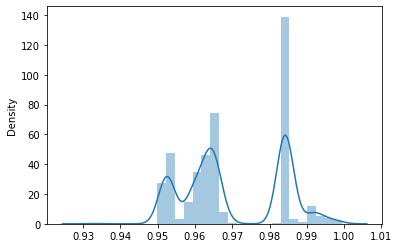

In [43]:
sns.distplot(u_out0_len)
pd.Series(u_out0_len).describe()

# R=50, C=20

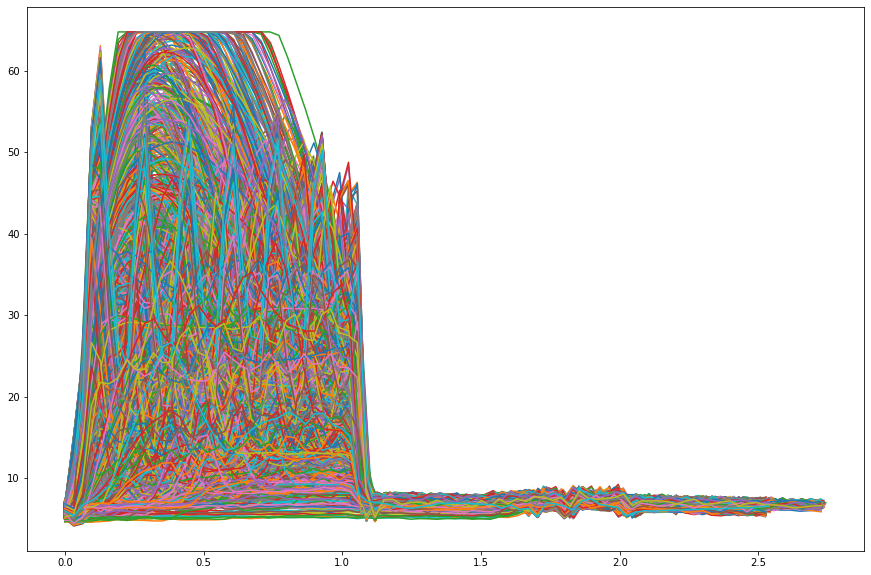

In [20]:
train_rc = train[(train['R']==50) & (train['C']==20)].reset_index()
b_ids = train_rc['breath_id'].unique()
plt.figure(figsize=(15, 10))
for b_id in b_ids:
    tmp_df = train_rc[train_rc['breath_id']==b_id]
    plt.plot(tmp_df['time_step'], tmp_df['pressure'], label='pressure')

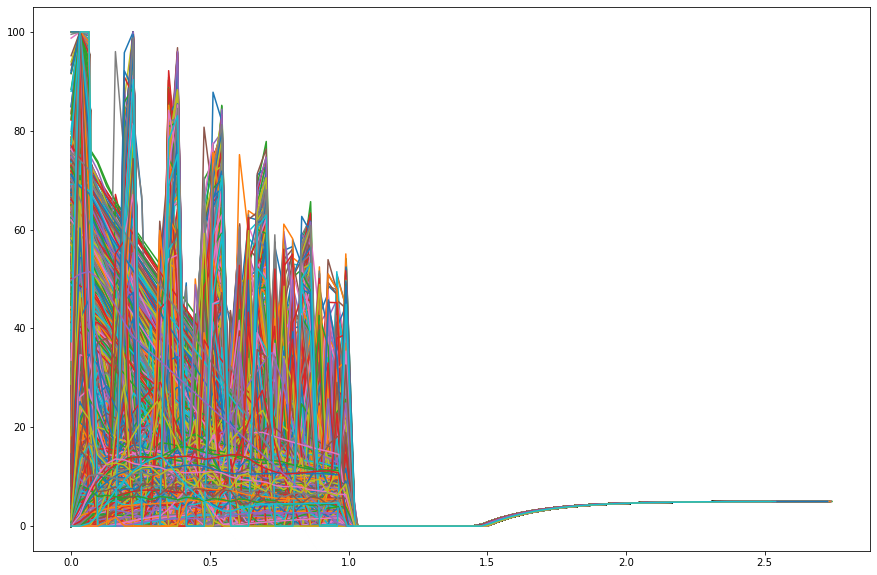

In [44]:
train_rc = train[(train['R']==50) & (train['C']==20)].reset_index()
b_ids = train_rc['breath_id'].unique()
plt.figure(figsize=(15, 10))
u_out0_len = []
for b_id in b_ids:
    tmp_df = train_rc[train_rc['breath_id']==b_id]
    plt.plot(tmp_df['time_step'], tmp_df['u_in'], label='u_in')
    u_out0_len.append(tmp_df[tmp_df['u_out']==0]['time_step'].values[-1])

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


count    8260.000000
mean        0.977293
std         0.013445
min         0.930772
25%         0.964739
50%         0.968238
75%         0.990183
max         0.999621
dtype: float64

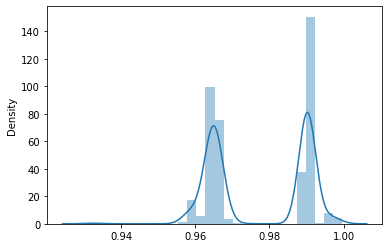

In [45]:
sns.distplot(u_out0_len)
pd.Series(u_out0_len).describe()

# R=50, C=10

In [211]:
train_rc = train[(train['R']==50) & (train['C']==10)].reset_index()

In [255]:
train_rc_g_by = train_rc.groupby('breath_id')['u_in'].apply(list).apply(pd.Series)
kmeans = TimeSeriesKMeans(n_clusters=4, metric="dtw", random_state=777)
kmeans.fit(train_rc_g_by.values)

TimeSeriesKMeans(metric='dtw', n_clusters=4, random_state=777)

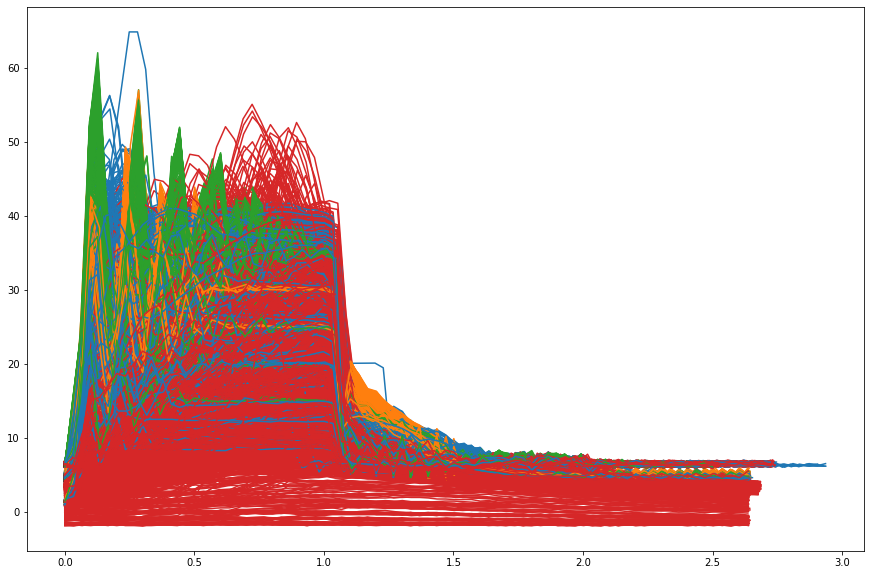

In [256]:
train_rc = train[(train['R']==50) & (train['C']==10)].reset_index()
b_ids = train_rc['breath_id'].unique()
plt.figure(figsize=(15, 10))
for i, b_id in enumerate(b_ids):
    tmp_df = train_rc[train_rc['breath_id']==b_id]
    plt.plot(tmp_df['time_step'], tmp_df['pressure'], label='pressure', color=colors[kmeans.labels_[i]])

In [253]:
b_ids = train_rc['breath_id'].unique()
plt.figure(figsize=(15, 10))
for i in range(4):
    if i != 0:
        continue
    tmp_df = train_rc[train_rc['breath_id'].isin(b_ids[kmeans.labels_==i])]
    plt.plot(tmp_df['time_step'], tmp_df['pressure'], label='pressure', color=colors[kmeans.labels_[i]])

OverflowError: Exceeded cell block limit (set 'agg.path.chunksize' rcparam)

<Figure size 1080x720 with 1 Axes>

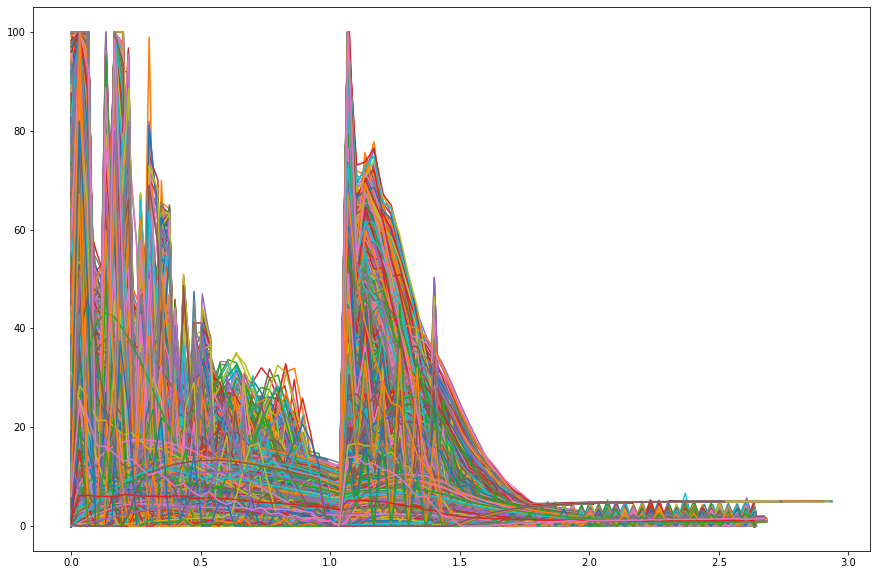

In [46]:
train_rc = train[(train['R']==50) & (train['C']==10)].reset_index()
b_ids = train_rc['breath_id'].unique()
plt.figure(figsize=(15, 10))
u_out0_len = []
for b_id in b_ids:
    tmp_df = train_rc[train_rc['breath_id']==b_id]
    plt.plot(tmp_df['time_step'], tmp_df['u_in'], label='u_in')
    u_out0_len.append(tmp_df[tmp_df['u_out']==0]['time_step'].values[-1])

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


count    13677.000000
mean         0.971051
std          0.011332
min          0.790936
25%          0.964770
50%          0.968887
75%          0.980588
max          0.999748
dtype: float64

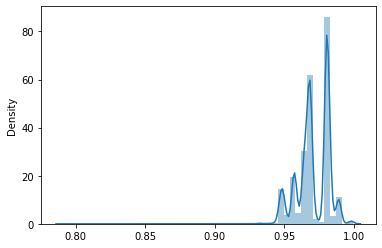

In [47]:
sns.distplot(u_out0_len)
pd.Series(u_out0_len).describe()

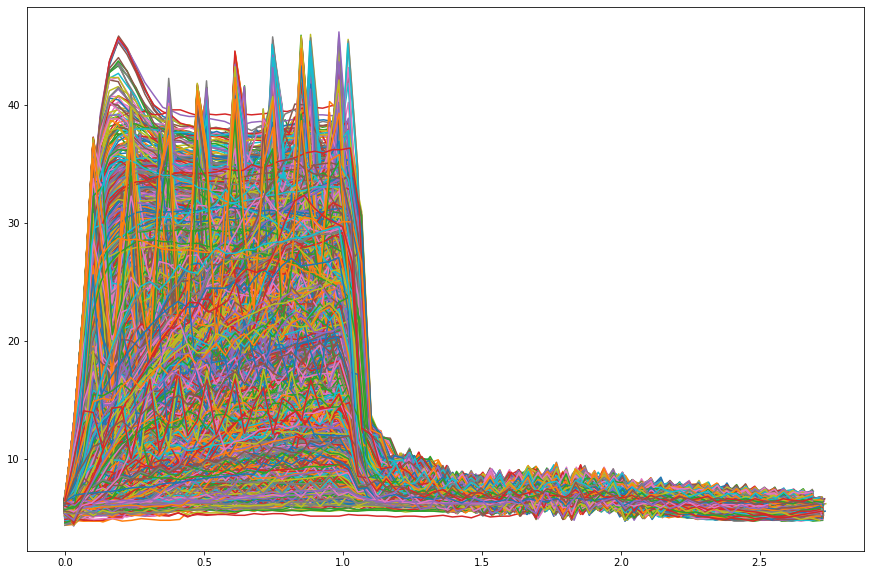

In [17]:
train_rc = train[(train['R']==20) & (train['C']==50)].reset_index()
b_ids = train_rc['breath_id'].unique()
plt.figure(figsize=(15, 10))
for b_id in b_ids:
    tmp_df = train_rc[train_rc['breath_id']==b_id]
    plt.plot(tmp_df['time_step'], tmp_df['pressure'], label='pressure')

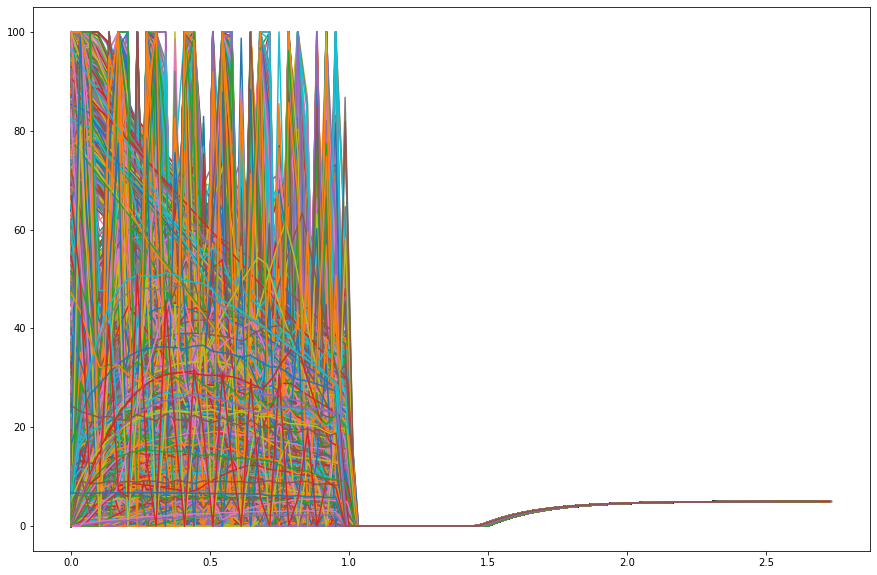

In [75]:
train_rc = train[(train['R']==20) & (train['C']==50)].reset_index()
b_ids = train_rc['breath_id'].unique()
plt.figure(figsize=(15, 10))
for b_id in b_ids:
    tmp_df = train_rc[train_rc['breath_id']==b_id]
    plt.plot(tmp_df['time_step'], tmp_df['u_in'], label='u_in')

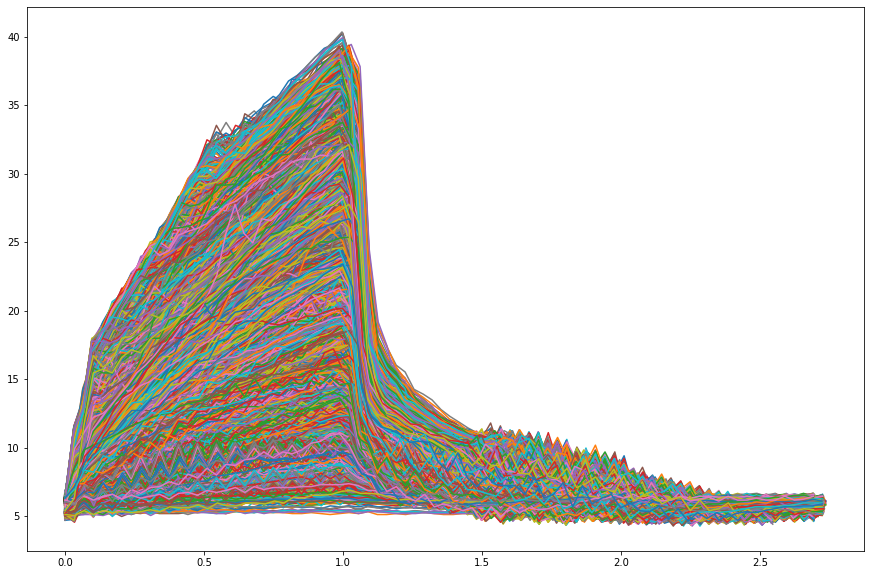

In [18]:
train_rc = train[(train['R']==5) & (train['C']==50)].reset_index()
b_ids = train_rc['breath_id'].unique()
plt.figure(figsize=(15, 10))
for b_id in b_ids:
    tmp_df = train_rc[train_rc['breath_id']==b_id]
    plt.plot(tmp_df['time_step'], tmp_df['pressure'], label='pressure')